<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to analyze the monitoring data available on HDFS (analytix)__ and plots a heatmap of loadAvg across machines in a particular service.

### Connect to the cluster (analytix)

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import from_unixtime, when, col
from pyspark.sql.types import *
from pyspark.sql.functions import from_json

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data
*path_on_hdfs_to_your_data*

In [3]:
df = spark.read.json("/project/itmon/archive/lemon/hadoop_ng/2018-04/")

### check the structure

In [4]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- aggregated: string (nullable = true)
 |-- body: string (nullable = true)
 |-- entity: string (nullable = true)
 |-- metric_id: string (nullable = true)
 |-- metric_name: string (nullable = true)
 |-- producer: string (nullable = true)
 |-- submitter_environment: string (nullable = true)
 |-- submitter_host: string (nullable = true)
 |-- submitter_hostgroup: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- toplevel_hostgroup: string (nullable = true)
 |-- type: string (nullable = true)
 |-- version: string (nullable = true)



### Filter for loadAvg
_https://metricmgr.cern.ch/metric/20002/_

In [5]:
body_schema = StructType([StructField("LoadAvg",DoubleType())])
df_loadAvg = df.where(col("metric_id") == "20002").withColumn('body', from_json('body', body_schema))

### Create temporary table view

In [6]:
# body_schema = spark.read.json(df_loadAvg.rdd.map(lambda row: row.body)).schema
df_loadAvg.createOrReplaceTempView("loadAvg")

### Do the heavylifting in spark and collect aggregated view to panda DF

In [7]:
df_loadAvg_pandas = spark.sql("SELECT substring(submitter_host,7,length(submitter_host)) as host, \
                                      avg(body.LoadAvg) as avg, \
                                      hour(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) as hr \
                               FROM loadAvg \
                               WHERE submitter_hostgroup like 'hadoop_ng/nxcals%' \
                               AND dayofmonth(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) = 22 \
                               GROUP BY hour(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')), submitter_host")\
                    .toPandas()

### Visualize with seaborn

Text(0.5,1,u'Heatmap of loadAvg for NXCals service on 22nd April 2018')

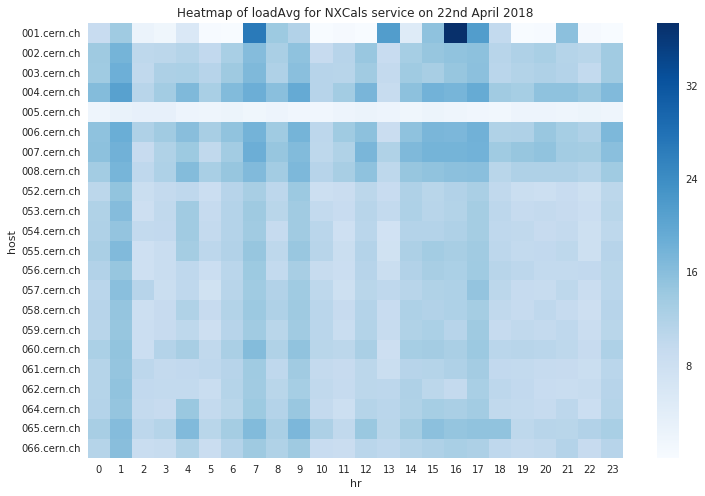

In [9]:
# heatmap of loadAvg
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_loadAvg_pandas.pivot(index='host', columns='hr', values='avg'), cmap="Blues")
ax.set_title("Heatmap of loadAvg for NXCals service on 22nd April 2018")